# Kelvin-Helmholtz Instability

We will represent an incompressible, viscous, diffusive, Boussinesq, stratified fluid to simulate a Kelvin-Helmholtz instability.

<img src="./Stratified_KH_small.jpeg" width="600" height="300" />



This exercise was designed for the course Waves and Instabilities in Geophysical Fluid Dynamics of the Master's Degree in Advanced Physics and Applied Mathematics, at University of the Balearic Islands (Spain).

Author: Daniel Argüeso
Email: d.argueso@uib.es

## Import modules

In [152]:
## Import modules
import numpy as np
from dedalus import public as de
from dedalus.extras import flow_tools
import matplotlib.pyplot as plt
import h5py
import time
%matplotlib inline
#%matplotlib notebook

## Import and set logging

Here, we set logging to `INFO` level. Currently, by default, Dedalus sets its logging output to `DEBUG`, which produces more info than we need here.

In [153]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

## Define the problem

### Set problem domain

You need to define the domain of the problem. The first two items indicate the aspect ratio. For exmaple (2,1). The second one indicates the number of grid points in each direction. They should be consistent with the aspect ratio

In [154]:
Lx, Ly = (2., 1.)
nx, ny = (512, 256)

### Create bases and domain

They basically define the transformation between the grid space and the spectral space. There are various types of basis, but the most popular are:
- Fourier: to define periodic functions in an intervarl (usually the direction of the flow)
- Chebyshev: general functions in an interval (they require boundary conditions, usually top and bottom)

For each basis we specify the direction, the dimensions, the interval and the dealising. Dealising is used to evaluate operators in the Fourier space and for numerical stability. We use the default 3/2.

Then, the domain, which combines both bases and the dimensions above to define the problem domain

In [155]:
x_basis = de.Fourier("x", nx, interval=(0, Lx), dealias=3 / 2)
y_basis = de.Chebyshev("y", ny, interval=(-Ly / 2, Ly / 2), dealias=3 / 2)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

### Set parameters

In [156]:
Reynolds = 5e4
g = 9.81
Schmidt = 1e2
Prandtl = 1e2

### Define the problem and the equations

We define the problem. We have different options, but we will use Initial value problem (IVP) in all of our exercises.
When we define the problem, we have to specify the domain, the variables, the parameters and the equations.

In the first command, we take the domain specifications we defined before and we define the variables that the problem will use. Here, for example we have pressure, horizontal and vertical velocities, and density. On top of that we also have vertical derivatives of density, and velocities, which we will need to specify the equations.

In [157]:
#With diffusivity
problem = de.IVP(domain, variables=["p", "u", "uy", "v", "vy", "rho", "rhoy"])
#Without diffusivity
#problem = de.IVP(domain, variables=["p", "u", "uy", "v", "vy", "rho"])


In [158]:
problem.parameters['Re'] = Reynolds
problem.parameters['g'] = g
problem.parameters['Sc'] = Schmidt 
problem.parameters['Pr'] = Prandtl


These are the problem equations:

**Equations**

See CR 14.2 (PDF version pg 429 - equations pg 431)

Next we will define the equations that will be solved on this domain.  The equations are

$$ \partial_t u + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} u + \frac{\partial_x p}{\rho_0} =  \frac{1}{{\rm Re}} \nabla^2 u $$
$$ \partial_t v + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} v + \frac{\partial_y p}{\rho_0} + \frac{\rho g}{\rho_0} =  \frac{1}{{\rm Re}} \nabla^2 v $$
$$ \boldsymbol{\nabla}\boldsymbol{\cdot}\boldsymbol{u} = 0 $$
$$ \partial_t \rho + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} \rho = 0 $$

The equations are written such that the left-hand side (LHS) is treated implicitly, and the right-hand side (RHS) is treated explicitly.  The LHS is limited to only linear terms, though linear terms can also be placed on the RHS.  Since $y$ is our special direction in this example, we also restrict the LHS to be at most first order in derivatives with respect to $y$.

**Note**: Note that, unlike the R-T example, there is no diffusivity in the density equation here. You can try to add diffusivity like we did for the R-T example and see what happens. You can use Prandtl number =1. The equation will thus be:

$$ \partial_t \rho + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} \rho = \frac{1}{{\rm PrSc}} \nabla^2 \rho $$
    

but you need to make some changes to the number of variables and boundary conditions.

In [159]:
problem.add_equation("dt(u) + dx(p) - 1/Re*(dx(dx(u)) + dy(uy)) = - u*dx(u) - v*uy")
problem.add_equation("dt(v) + dy(p) - 1/Re*(dx(dx(v)) + dy(vy)) + g*rho = -u*dx(v) - v*vy")
problem.add_equation("dx(u) + vy = 0")
problem.add_equation("dt(rho) - 1/(Pr*Sc)*(dx(dx(rho)) + dy(rhoy)) = - u*dx(rho) - v*rhoy")
#problem.add_equation("dt(s) = - u*dx(rho) - v*rhoy")
problem.add_equation("vy - dy(v) = 0") 
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("rhoy - dy(rho) = 0")

### Define the boundary conditions

As a general rule, for every derivate on y (our special dimension, Chebyshev), we need to add one boundary conditions. 
One of them is the pressure gauge.

Here you will need 5 different boundary conditions, including hte pressure gauge.

* Two for horizontal velocity (consistent with the bacgkround flow). Dirichlet type, no-slip.
* Two for vertical velocity. No-slip, no outgoing or incoming flow at the top and bottom walls.
* Pressure gauge.

Note that we have a special boundary condition for the $k_x=0$ mode (singled out by `condition="(dx==0)"`).  This is because the continuity equation implies $\partial_y v=0$ if $k_x=0$; thus, $v=0$ on the top and bottom are redundant boundary conditions.  We replace one of these with a gauge choice for the pressure.

In [160]:
problem.add_bc("left(u) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("integ(p,'y') = 0", condition="(nx == 0)")
problem.add_bc("left(rho) = 0.5")
problem.add_bc("right(rho) = -0.5")

## Define the solver

### Timestepping

We have different numerical schemes we can choose from. In our examples, we will use the RK443, but feel free to try others. You may read the documentation to see the full range of options.

In [161]:
ts = de.timesteppers.RK443

### Building the solver

Here we simply initialize the solver.

In [162]:
solver =  problem.build_solver(ts)

x = domain.grid(0)
y = domain.grid(1)
u = solver.state["u"]
uy = solver.state['uy']
v = solver.state["v"]
vy = solver.state["vy"]
p = solver.state["p"]
rho = solver.state["rho"]
rhoy = solver.state["rhoy"]

2023-12-10 13:30:53,394 pencil 0/1 INFO :: Building pencil matrix 1/256 (~0%) Elapsed: 0s, Remaining: 5s, Rate: 5.6e+01/s
2023-12-10 13:30:53,781 pencil 0/1 INFO :: Building pencil matrix 26/256 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 6.4e+01/s
2023-12-10 13:30:54,179 pencil 0/1 INFO :: Building pencil matrix 52/256 (~20%) Elapsed: 1s, Remaining: 3s, Rate: 6.5e+01/s
2023-12-10 13:30:54,584 pencil 0/1 INFO :: Building pencil matrix 78/256 (~30%) Elapsed: 1s, Remaining: 3s, Rate: 6.5e+01/s
2023-12-10 13:30:54,992 pencil 0/1 INFO :: Building pencil matrix 104/256 (~41%) Elapsed: 2s, Remaining: 2s, Rate: 6.4e+01/s
2023-12-10 13:30:55,395 pencil 0/1 INFO :: Building pencil matrix 130/256 (~51%) Elapsed: 2s, Remaining: 2s, Rate: 6.4e+01/s
2023-12-10 13:30:55,795 pencil 0/1 INFO :: Building pencil matrix 156/256 (~61%) Elapsed: 2s, Remaining: 2s, Rate: 6.5e+01/s
2023-12-10 13:30:56,192 pencil 0/1 INFO :: Building pencil matrix 182/256 (~71%) Elapsed: 3s, Remaining: 1s, Rate: 6.5e+01/s
2023-1

Set the solver parameters

Here we define some paramters, to help stop the simulation. In our case, we define the maximum duration, but we can define others.

In [163]:
solver.stop_sim_time = 10.01
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

Set initial timestep and CFL conditions

We set the initial timestep, which will be later modified to ensure stability and optimize the simulation depending on the problem itself. We can also define cfl conditions based on velocities.

In [164]:

initial_dt = 0.2 * Lx / nx
cfl = flow_tools.CFL(solver,initial_dt,safety=0.8,threshold=0.05)
cfl.add_velocities(("u", "v"))

### Initial conditions

Once the problem and the solver are set, we need to describe the initial conditions. These are critical to the problem and may be the difference between success and failure. A right choice of the initial conditions will produce the instability we are studying or simply make the model crash.

Set initial conditions with a sinusoidal perturbation in vertical velocity

In [165]:
a = 0.02
amp = -0.2
sigma = 1.0
flow = -1.0
N = 4
u["g"] = flow * np.tanh(4 * y / a) - 0.2
rho["g"] = amp * np.tanh(3 * y / a)
v["g"] = amp * np.exp(-y**2 / sigma**2) * np.sin(N * np.pi * x / Lx)


Plot initial density and velocities

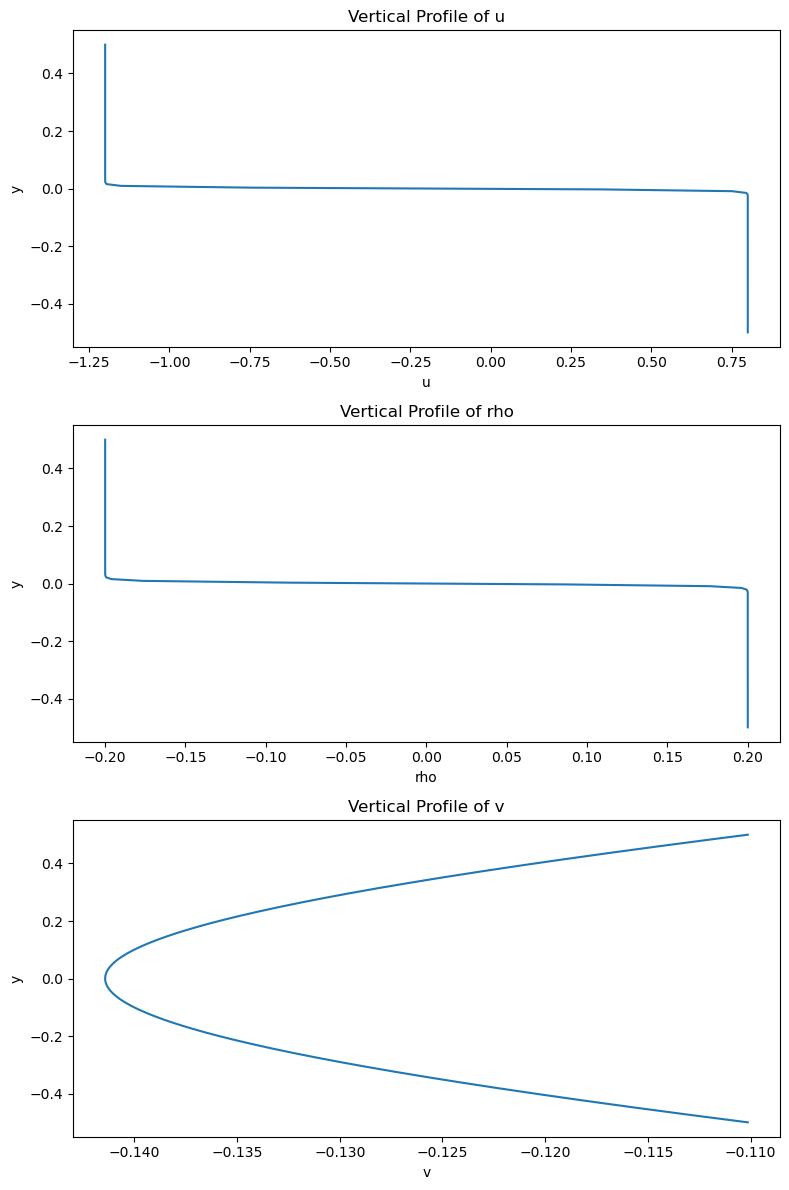

In [166]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Plot vertical profile of u
axes[0].plot(np.mean(u['g'], axis=0), y[0])
axes[0].set_ylabel('y')
axes[0].set_xlabel('u')
axes[0].set_title('Vertical Profile of u')

# Plot vertical profile of rho
axes[1].plot(np.mean(rho['g'], axis=0), y[0])
axes[1].set_ylabel('y')
axes[1].set_xlabel('rho')
axes[1].set_title('Vertical Profile of rho')

# Plot vertical profile of v
axes[2].plot(v['g'][int(nx/4),:],y[0])
#axes[2].plot(np.mean(v['g'], axis=0), y[0])
axes[2].set_ylabel('y')
axes[2].set_xlabel('v')
axes[2].set_title('Vertical Profile of v')

plt.tight_layout()
plt.show()


Plot initial vertical velocity

In [167]:
# plt.close()
# plt.plot(v['g'][int(nx/4),:],y[0])
# plt.ylabel('y')
# plt.xlabel('vertical velocity')
# plt.savefig("KH_velocity.png")

## Solving

In this step run the solver. At the same time we save some information for analysis we may want to make later on. And draw the plots every certain number of timesteps. Saving the analysis is not necessary, but it may be helpful to modify plots without having to run the entire simulation again.

Prepare the variables that will be saved for analysis (this is optional)

In [168]:

analysis = solver.evaluator.add_file_handler("analysis", sim_dt=0.1, max_writes=1000)
analysis.add_task("rho")
analysis.add_task("u")
analysis.add_task("v")
analysis.add_task('0.5*(u**2+v**2)',name='KE',scales=(3/2,3/2))
analysis.add_task('0.5*(dx(v)-uy)**2',name='enstrophy')
solver.evaluator.vars['Lx'] = Lx
analysis.add_task("integ(rho,'x')/Lx", name='rho profile')


### Plotting initial state

Make the plot for the initial state
(remember to use dealias before plotting, see R-T example)

2023-12-10 13:30:58,060 __main__ 0/1 INFO :: Starting loop
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
2

KeyboardInterrupt: 

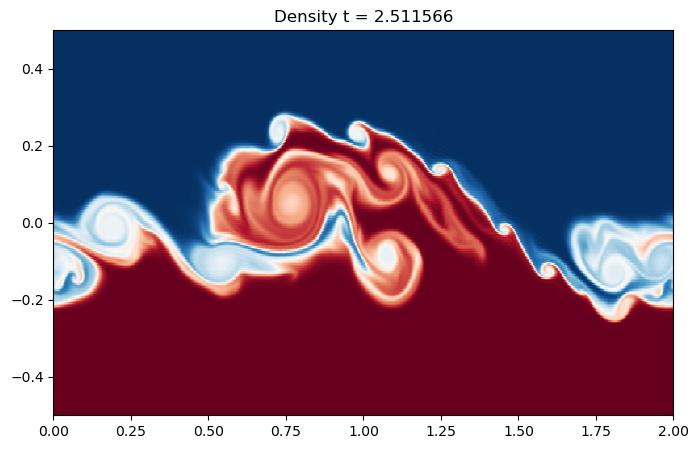

In [169]:
x = domain.grid(0,scales=domain.dealias)
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(figsize=(8,5))
rho.set_scales(domain.dealias)

p = axis.pcolormesh(xm, ym, rho["g"].T, cmap="RdBu_r")
axis.set_title("Density t = %f" % solver.sim_time)
axis.set_xlim([0,2.])
axis.set_ylim([-0.5,0.5])
#plt.savefig(f'./Kelvin-Helmholtz_instability_000.png')


logger.info('Starting loop')
start_time = time.time()
nt=0
while solver.ok:
    dt = cfl.compute_dt()
    solver.step(dt)
    print(solver.iteration)
    if solver.iteration % 10 == 0:
        # Update plot of scalar field
        p.set_array(rho["g"].T)
        axis.set_title("Density t = %f" % solver.sim_time)
        fig.canvas.draw()
        plt.savefig(f'./Kelvin-Helmholtz_instability_viscous_diffusivity_{nt:03d}.png')
        nt+=1
        
#Video

# def init():
#     axis.set_xlim([0,2.])
#     axis.set_ylim([-0.5,0.5])
#     return p,

# def update(frame):
    
#     if solver.ok:
#         dt = cfl.compute_dt()
#         solver.step(dt)
#         p.set_array(np.ravel(rho['g'][:,:].T))
#         axis.set_title(f't = {solver.sim_time}')
    

# #mimation = FuncAnimation(fig, update,interval = 300)

# anim = animation.FuncAnimation(fig, update, frames=3000, interval=300)
# anim.save('KH.mp4', fps=20)

In [ ]:
# from IPython.display import HTML
# HTML(anim.to_html5_video())

### Move into solving loop

### ending program with information

In [ ]:
end_time = time.time()
logger.info('Run time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)

## Analysis

As an example of doing some analysis, we will load in the horizontally averaged profiles of the scalar field $s$ and plot them.

In [ ]:
# # Read in the data
# f = h5py.File('analysis/analysis_s1/analysis_s1_p0.h5','r')
# y = f['/scales/y/1.0'][:]
# t = f['scales']['sim_time'][:]
# rho_ave = f['tasks']['rho profile'][:]
# f.close()

# rho_ave = rho_ave[:,0,:] # remove length-one x dimension

In [ ]:
# fig, axis = plt.subplots(figsize=(8,6))
# for i in range(0,31,6):
#   axis.plot(y,rho_ave[i,:],label='t=%4.2f' %t[i])

# plt.xlim([-0.5,0.5])
# plt.ylim([0,1])
# plt.ylabel(r'$\frac{\int \ rho dx}{L_x}$',fontsize=24)
# plt.xlabel(r'$y$',fontsize=24)
# plt.legend(loc='lower right').draw_frame(False)